# Visualization and interpretability of a CNN

## Setup

In [1]:
import cv2
import numpy as np
import requests
from PIL import Image
from saliency import saliency
from gradcam import GradCAM
from torchvision import models, transforms

In [2]:
#load pretrained resnet model
model = models.resnet18(pretrained=True)
print(model)

dimension = (224, 224)
#define transforms to preprocess input image into format expected by model
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

#transforms to resize image to the size expected by pretrained model,
#convert PIL image to tensor, and
#normalize the image
transform = transforms.Compose([
    transforms.Resize(dimension),
    transforms.ToTensor(),
    normalize,          
])

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Saliency maps

Indice of the best score: tensor([291])
Score: tensor([5.3104], grad_fn=<MaxBackward0>)


/Users/armandbryan/Documents/articles implementation/articles/gradcam and saliency/saliency.py:64: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


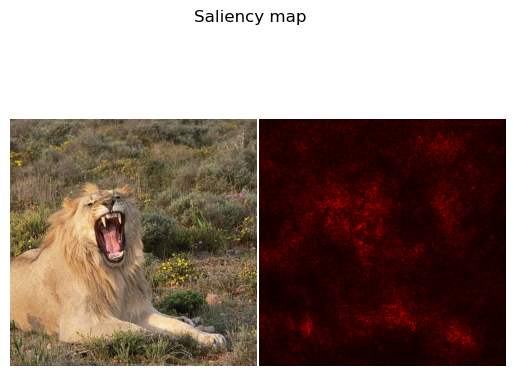

In [3]:
url = 'https://cdn.futura-sciences.com/buildsv6/images/square870/1/2/5/125d2b93fe_50036035_panthera-leop1040181.jpg'
image = Image.open(requests.get(url, stream = True).raw).convert("RGB")
saliency(image, model)

Indice of the best score: tensor([291])
Score: tensor([19.9445], grad_fn=<MaxBackward0>)


/Users/armandbryan/Documents/articles implementation/articles/gradcam and saliency/saliency.py:64: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


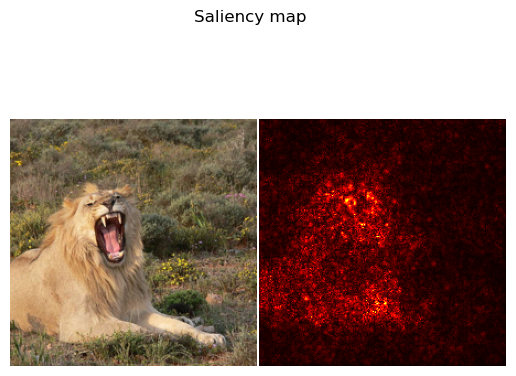

In [4]:
image_r = image.resize(dimension)
saliency(image_r, model, transform=transform)

It is observed that a transformed image can exhibit a saliency map that is initially less interpretable, yet be associated with a higher confidence score than the original image, whose saliency map clearly highlights a lion.

This observation suggests that a model's ability to accurately detect an object is not necessarily correlated with the ease of interpretation of its saliency map. More performant models, such as ResNet-50 and ResNet-101, may produce less intuitive saliency maps for the original image, despite achieving high confidence scores.

This increased complexity in saliency maps could be attributed to the ability of deeper models to capture subtle and abstract features that contribute to classification, but which are not immediately apparent to the human eye. Analysis of these more complex saliency maps may require additional expertise or specialized interpretation tools to derive meaningful insights.

## GradCAM

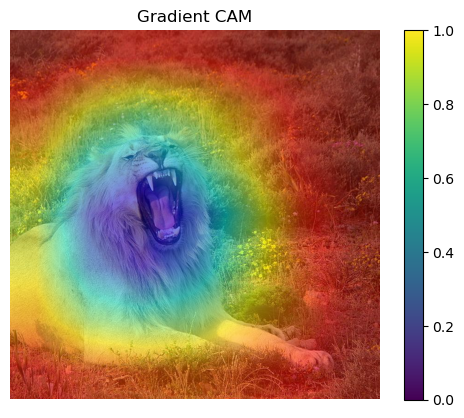

In [5]:
gcam = GradCAM(image = image, model = model, target_layer = 'layer4.1.conv2', transform = transform) #We use the 'layer4.1.conv2' because it is last layer of resnet18

preds, _ = gcam.forward()
class_idx = preds.argmax().item()
gcam.visualize(class_idx)

In [6]:
input_video_path = 'Pride Lion walking in road.mp4'
output_video_path = 'lion_gradcam_video.mp4'

cap = cv2.VideoCapture(input_video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
for i in range(frame_count):
    ret, frame = cap.read()
    if not ret:
        break

    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(image)

    gcam = GradCAM(image=image, model=model, target_layer='layer4.1.conv2', transform=transform)
    preds, _ = gcam.forward()
    class_idx = preds.argmax().item()

    cam = gcam.generate_cam(class_idx)
    cam = cv2.resize(cam, (frame_width, frame_height))

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    frame = np.float32(frame) / 255
    cam_frame = heatmap + frame
    cam_frame = cam_frame / np.max(cam_frame)
    cam_frame = np.uint8(255 * cam_frame)

    out.write(cam_frame)
    if i % 10 == 0:
        print(f"Traitement de la frame {i}/{frame_count}")

cap.release()
out.release()
cv2.destroyAllWindows()
print("Video generated.")

Traitement de la frame 0/394
Traitement de la frame 10/394
Traitement de la frame 20/394
Traitement de la frame 30/394
Traitement de la frame 40/394
Traitement de la frame 50/394
Traitement de la frame 60/394
Traitement de la frame 70/394
Traitement de la frame 80/394
Traitement de la frame 90/394
Traitement de la frame 100/394
Traitement de la frame 110/394
Traitement de la frame 120/394
Traitement de la frame 130/394
Traitement de la frame 140/394
Traitement de la frame 150/394
Traitement de la frame 160/394
Traitement de la frame 170/394
Traitement de la frame 180/394
Traitement de la frame 190/394
Traitement de la frame 200/394
Traitement de la frame 210/394
Traitement de la frame 220/394
Traitement de la frame 230/394
Traitement de la frame 240/394
Traitement de la frame 250/394
Traitement de la frame 260/394
Traitement de la frame 270/394
Traitement de la frame 280/394
Traitement de la frame 290/394
Traitement de la frame 300/394
Traitement de la frame 310/394
Traitement de la fr